# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, Ridge, PoissonRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, root_mean_squared_error, max_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import patsy

pd.set_option("display.max_columns", None)

# Games Data

In [2]:
data_path = os.path.join("..", "data", "games.csv")
df = pd.read_csv(data_path, parse_dates=["Date", "Open"], date_format="%Y-%m-%d", index_col=0)

df = df[df["N"] == 0].drop(columns="N")
df["Timestamp"] = df["Date"].astype(int)
df = df[df["Season"] > 19]

display(df.head(), df.shape)

,Season,Date,HID,AID,POFF,Open,OddsH,OddsA,H,A,HSC,ASC,HFGM,AFGM,HFGA,AFGA,HFG3M,AFG3M,HFG3A,AFG3A,HFTM,AFTM,HFTA,AFTA,HORB,AORB,HDRB,ADRB,HRB,ARB,HAST,AAST,HSTL,ASTL,HBLK,ABLK,HTOV,ATOV,HPF,APF,Timestamp
22420,20,1994-11-08,43,20,0,1994-11-07,1.441652,2.749907,0,1,108,111,42.0,42.0,96.0,94.0,7.0,8.0,21.0,18.0,17.0,19.0,23.0,28.0,10.0,14.0,41.0,41.0,51.0,55.0,27.0,16.0,9.0,9.0,4.0,6.0,20.0,22.0,26.0,30.0,784252800000000000
22421,20,1994-11-08,4,33,0,1994-11-07,1.314653,3.444882,1,0,102,91,41.0,41.0,82.0,84.0,4.0,0.0,13.0,7.0,16.0,9.0,21.0,15.0,15.0,12.0,27.0,23.0,42.0,35.0,21.0,21.0,5.0,6.0,7.0,4.0,16.0,13.0,19.0,18.0,784252800000000000
22422,20,1994-11-08,13,22,0,1994-11-07,1.289305,3.652356,0,1,108,117,41.0,42.0,95.0,85.0,4.0,6.0,12.0,13.0,22.0,27.0,29.0,33.0,13.0,14.0,26.0,39.0,39.0,53.0,25.0,26.0,10.0,3.0,7.0,3.0,8.0,17.0,29.0,25.0,784252800000000000
22423,20,1994-11-08,39,42,0,1994-11-07,2.309452,1.587971,1,0,93,67,35.0,25.0,73.0,80.0,4.0,3.0,11.0,13.0,19.0,14.0,22.0,19.0,6.0,10.0,46.0,26.0,52.0,36.0,21.0,13.0,7.0,8.0,4.0,5.0,21.0,19.0,21.0,25.0,784252800000000000
22424,20,1994-11-09,8,19,0,1994-11-08,1.120202,7.028674,1,0,122,97,43.0,39.0,74.0,93.0,7.0,3.0,19.0,10.0,29.0,16.0,45.0,21.0,11.0,20.0,27.0,27.0,38.0,47.0,24.0,21.0,10.0,12.0,8.0,3.0,20.0,22.0,21.0,35.0,784339200000000000


(6570, 41)

In [3]:
meta_columns = ["Season", "Date", "HID", "AID", "POFF", "H", "A", "HSC", "ASC", "OddsH", "OddsA", "Timestamp"]
df_bare = df[meta_columns]

display(df_bare.head(), df_bare.shape)

,Season,Date,HID,AID,POFF,H,A,HSC,ASC,OddsH,OddsA,Timestamp
22420,20,1994-11-08,43,20,0,0,1,108,111,1.441652,2.749907,784252800000000000
22421,20,1994-11-08,4,33,0,1,0,102,91,1.314653,3.444882,784252800000000000
22422,20,1994-11-08,13,22,0,0,1,108,117,1.289305,3.652356,784252800000000000
22423,20,1994-11-08,39,42,0,1,0,93,67,2.309452,1.587971,784252800000000000
22424,20,1994-11-09,8,19,0,1,0,122,97,1.120202,7.028674,784339200000000000


(6570, 12)

In [4]:
rename_columnsH = {
    "HID": "TeamID", "AID": "OpponentID", "H": "W", "OddsH": "TeamOdds", "OddsA": "OpponentOdds", "POFF": "TeamPOFF",
    "HSC": "TeamSC", "HFGM": "TeamFGM", "HFGA": "TeamFGA", "HFG3M": "TeamFG3M", "HFG3A": "TeamFG3A", "HFTM": "TeamFTM", "HFTA": "TeamFTA", "HORB": "TeamORB", "HDRB": "TeamDRB", "HRB": "TeamRB", "HAST": "TeamAST", "HSTL": "TeamSTL", "HBLK": "TeamBLK", "HTOV": "TeamTOV", "HPF": "TeamPF",
    "ASC": "OpponentSC", "AFGM": "OpponentFGM", "AFGA": "OpponentFGA", "AFG3M": "OpponentFG3M", "AFG3A": "OpponentFG3A", "AFTM": "OpponentFTM", "AFTA": "OpponentFTA", "AORB": "OpponentORB", "ADRB": "OpponentDRB", "ARB": "OpponentRB", "AAST": "OpponentAST", "ASTL": "OpponentSTL", "ABLK": "OpponentBLK", "ATOV": "OpponentTOV", "APF": "OpponentPF",
}


df_home_game_stats = df.copy().drop(columns=["A", "Open"]).rename(columns=rename_columnsH)

display(df_home_game_stats.head().set_index(["Season", "Date", "TeamID", "OpponentID"]))


rename_columnsA = {
    "HID": "OpponentID", "AID": "TeamID", "A": "W", "OddsH": "OpponentOdds", "OddsA": "TeamOdds", "POFF": "TeamPOFF",
    "HSC": "OpponentSC", "HFGM": "OpponentFGM", "HFGA": "OpponentFGA", "HFG3M": "OpponentFG3M", "HFG3A": "OpponentFG3A", "HFTM": "OpponentFTM", "HFTA": "OpponentFTA", "HORB": "OpponentORB", "HDRB": "OpponentDRB", "HRB": "OpponentRB", "HAST": "OpponentAST", "HSTL": "OpponentSTL", "HBLK": "OpponentBLK", "HTOV": "OpponentTOV", "HPF": "OpponentPF",
    "ASC": "TeamSC", "AFGM": "TeamFGM", "AFGA": "TeamFGA", "AFG3M": "TeamFG3M", "AFG3A": "TeamFG3A", "AFTM": "TeamFTM", "AFTA": "TeamFTA", "AORB": "TeamORB", "ADRB": "TeamDRB", "ARB": "TeamRB", "AAST": "TeamAST", "ASTL": "TeamSTL", "ABLK": "TeamBLK", "ATOV": "TeamTOV", "APF": "TeamPF",
}


df_away_game_stats = df.copy().drop(columns=["H", "Open"]).rename(columns=rename_columnsA)

display(df_away_game_stats.head().set_index(["Season", "Date", "TeamID", "OpponentID"]))
features = [
    "TeamPOFF", "TeamOdds", "OpponentOdds", "W", "TeamSC", "OpponentSC", "TeamFGM", "OpponentFGM", "TeamFGA", "OpponentFGA", "TeamFG3M", "OpponentFG3M",
    "TeamFG3A", "OpponentFG3A", "TeamFTM", "OpponentFTM", "TeamFTA", "OpponentFTA", "TeamORB", "OpponentORB", "TeamDRB", "OpponentDRB", "TeamRB", "OpponentRB",
    "TeamAST", "OpponentAST", "TeamSTL", "OpponentSTL", "TeamBLK", "OpponentBLK", "TeamTOV", "OpponentTOV", "TeamPF", "OpponentPF"
]


df_home_game_stats["H"] = 1
df_away_game_stats["H"] = 0

df_game_stats = pd.concat([df_home_game_stats, df_away_game_stats])

display(df_game_stats.head(), df_game_stats.shape)

TeamPOFF  TeamOdds  OpponentOdds  W  \
Season Date       TeamID OpponentID                                        
20     1994-11-08 43     20                 0  1.441652      2.749907  0   
                  4      33                 0  1.314653      3.444882  1   
                  13     22                 0  1.289305      3.652356  0   
                  39     42                 0  2.309452      1.587971  1   
       1994-11-09 8      19                 0  1.120202      7.028674  1   

                                     TeamSC  OpponentSC  TeamFGM  OpponentFGM  \
Season Date       TeamID OpponentID                                             
20     1994-11-08 43     20             108         111     42.0         42.0   
                  4      33             102          91     41.0         41.0   
                  13     22             108         117     41.0         42.0   
                  39     42              93          67     35.0         25.0   
       1994-11-09 8      19             122          97     43.0         39.0   

                                     TeamFGA  OpponentFGA  TeamFG3M  \
Season Date       TeamID OpponentID                                   
20     1994-11-08 43     20             96.0         94.0       7.0   
                  4      33             82.0         84.0       4.0   
                  13     22             95.0         85.0       4.0   
                  39     42             73.0         80.0       4.0   
       1994-11-09 8      19             74.0         93.0       7.0   

                                     OpponentFG3M  TeamFG3A  OpponentFG3A  \
Season Date       TeamID OpponentID                                         
20     1994-11-08 43     20                   8.0      21.0          18.0   
                  4      33                   0.0      13.0           7.0   
                  13     22                   6.0      12.0          13.0   
                  39     42                   3.0      11.0          13.0   
       1994-11-09 8      19                   3.0      19.0          10.0   

                                     TeamFTM  OpponentFTM  TeamFTA  \
Season Date       TeamID OpponentID                                  
20     1994-11-08 43     20             17.0         19.0     23.0   
                  4      33             16.0          9.0     21.0   
                  13     22             22.0         27.0     29.0   
                  39     42             19.0         14.0     22.0   
       1994-11-09 8      19             29.0         16.0     45.0   

                                     OpponentFTA  TeamORB  OpponentORB  \
Season Date       TeamID OpponentID                                      
20     1994-11-08 43     20                 28.0     10.0         14.0   
                  4      33                 15.0     15.0         12.0   
                  13     22                 33.0     13.0         14.0   
                  39     42                 19.0      6.0         10.0   
       1994-11-09 8      19                 21.0     11.0         20.0   

                                     TeamDRB  OpponentDRB  TeamRB  OpponentRB  \
Season Date       TeamID OpponentID                                             
20     1994-11-08 43     20             41.0         41.0    51.0        55.0   
                  4      33             27.0         23.0    42.0        35.0   
                  13     22             26.0         39.0    39.0        53.0   
                  39     42             46.0         26.0    52.0        36.0   
       1994-11-09 8      19             27.0         27.0    38.0        47.0   

                                     TeamAST  OpponentAST  TeamSTL  \
Season Date       TeamID OpponentID                                  
20     1994-11-08 43     20             27.0         16.0      9.0   
                  4      33             21.0         21.0      5.0   
                  13     22             

TeamPOFF  OpponentOdds  TeamOdds  W  \
Season Date       TeamID OpponentID                                        
20     1994-11-08 20     43                 0      1.441652  2.749907  1   
                  33     4                  0      1.314653  3.444882  0   
                  22     13                 0      1.289305  3.652356  1   
                  42     39                 0      2.309452  1.587971  0   
       1994-11-09 19     8                  0      1.120202  7.028674  0   

                                     OpponentSC  TeamSC  OpponentFGM  TeamFGM  \
Season Date       TeamID OpponentID                                             
20     1994-11-08 20     43                 108     111         42.0     42.0   
                  33     4                  102      91         41.0     41.0   
                  22     13                 108     117         41.0     42.0   
                  42     39                  93      67         35.0     25.0   
       1994-11-09 19     8                  122      97         43.0     39.0   

                                     OpponentFGA  TeamFGA  OpponentFG3M  \
Season Date       TeamID OpponentID                                       
20     1994-11-08 20     43                 96.0     94.0           7.0   
                  33     4                  82.0     84.0           4.0   
                  22     13                 95.0     85.0           4.0   
                  42     39                 73.0     80.0           4.0   
       1994-11-09 19     8                  74.0     93.0           7.0   

                                     TeamFG3M  OpponentFG3A  TeamFG3A  \
Season Date       TeamID OpponentID                                     
20     1994-11-08 20     43               8.0          21.0      18.0   
                  33     4                0.0          13.0       7.0   
                  22     13               6.0          12.0      13.0   
                  42     39               3.0          11.0      13.0   
       1994-11-09 19     8                3.0          19.0      10.0   

                                     OpponentFTM  TeamFTM  OpponentFTA  \
Season Date       TeamID OpponentID                                      
20     1994-11-08 20     43                 17.0     19.0         23.0   
                  33     4                  16.0      9.0         21.0   
                  22     13                 22.0     27.0         29.0   
                  42     39                 19.0     14.0         22.0   
       1994-11-09 19     8                  29.0     16.0         45.0   

                                     TeamFTA  OpponentORB  TeamORB  \
Season Date       TeamID OpponentID                                  
20     1994-11-08 20     43             28.0         10.0     14.0   
                  33     4              15.0         15.0     12.0   
                  22     13             33.0         13.0     14.0   
                  42     39             19.0          6.0     10.0   
       1994-11-09 19     8              21.0         11.0     20.0   

                                     OpponentDRB  TeamDRB  OpponentRB  TeamRB  \
Season Date       TeamID OpponentID                                             
20     1994-11-08 20     43                 41.0     41.0        51.0    55.0   
                  33     4                  27.0     23.0        42.0    35.0   
                  22     13                 26.0     39.0        39.0    53.0   
                  42     39                 46.0     26.0        52.0    36.0   
       1994-11-09 19     8                  27.0     27.0        38.0    47.0   

                                     OpponentAST  TeamAST  OpponentSTL  \
Season Date       TeamID OpponentID                                      
20     1994-11-08 20     43                 27.0     16.0          9.0   
                  33     4                  21.0     21.0          5.0   
                  22    

,Season,Date,TeamID,OpponentID,TeamPOFF,TeamOdds,OpponentOdds,W,TeamSC,OpponentSC,TeamFGM,OpponentFGM,TeamFGA,OpponentFGA,TeamFG3M,OpponentFG3M,TeamFG3A,OpponentFG3A,TeamFTM,OpponentFTM,TeamFTA,OpponentFTA,TeamORB,OpponentORB,TeamDRB,OpponentDRB,TeamRB,OpponentRB,TeamAST,OpponentAST,TeamSTL,OpponentSTL,TeamBLK,OpponentBLK,TeamTOV,OpponentTOV,TeamPF,OpponentPF,Timestamp,H
22420,20,1994-11-08,43,20,0,1.441652,2.749907,0,108,111,42.0,42.0,96.0,94.0,7.0,8.0,21.0,18.0,17.0,19.0,23.0,28.0,10.0,14.0,41.0,41.0,51.0,55.0,27.0,16.0,9.0,9.0,4.0,6.0,20.0,22.0,26.0,30.0,784252800000000000,1
22421,20,1994-11-08,4,33,0,1.314653,3.444882,1,102,91,41.0,41.0,82.0,84.0,4.0,0.0,13.0,7.0,16.0,9.0,21.0,15.0,15.0,12.0,27.0,23.0,42.0,35.0,21.0,21.0,5.0,6.0,7.0,4.0,16.0,13.0,19.0,18.0,784252800000000000,1
22422,20,1994-11-08,13,22,0,1.289305,3.652356,0,108,117,41.0,42.0,95.0,85.0,4.0,6.0,12.0,13.0,22.0,27.0,29.0,33.0,13.0,14.0,26.0,39.0,39.0,53.0,25.0,26.0,10.0,3.0,7.0,3.0,8.0,17.0,29.0,25.0,784252800000000000,1
22423,20,1994-11-08,39,42,0,2.309452,1.587971,1,93,67,35.0,25.0,73.0,80.0,4.0,3.0,11.0,13.0,19.0,14.0,22.0,19.0,6.0,10.0,46.0,26.0,52.0,36.0,21.0,13.0,7.0,8.0,4.0,5.0,21.0,19.0,21.0,25.0,784252800000000000,1
22424,20,1994-11-09,8,19,0,1.120202,7.028674,1,122,97,43.0,39.0,74.0,93.0,7.0,3.0,19.0,10.0,29.0,16.0,45.0,21.0,11.0,20.0,27.0,27.0,38.0,47.0,24.0,21.0,10.0,12.0,8.0,3.0,20.0,22.0,21.0,35.0,784339200000000000,1


(13140, 40)

In [5]:
# Possessions
df_game_stats["TeamPoss"] = 0.5 * (df_game_stats["TeamFGA"] + 0.475 * df_game_stats["TeamFTA"] - df_game_stats["TeamORB"] + df_game_stats["TeamTOV"])
df_game_stats["OpponentPoss"] = 0.5 * (df_game_stats["OpponentFGA"] + 0.475 * df_game_stats["OpponentFTA"] - df_game_stats["OpponentORB"] + df_game_stats["OpponentTOV"])

# Offensive and Defensive Rating
df_game_stats["TeamORtg"] = df_game_stats["TeamSC"] / (df_game_stats["TeamPoss"] + df_game_stats["OpponentPoss"])
df_game_stats["TeamDRtg"] = df_game_stats["OpponentSC"] / (df_game_stats["TeamPoss"] + df_game_stats["OpponentPoss"])


display(df_game_stats[["Season", "Date", "TeamID", "OpponentID", "W", "TeamORtg", "TeamDRtg"]].head(), df_game_stats.shape)

agg = {
    "TeamORtg": "mean",
    "TeamDRtg": "mean",
    "Timestamp": "max"

}

df_team_season_stats = df_game_stats \
    .groupby(["Season", "TeamID"]) \
    .rolling(1_000_000, min_periods=1, closed="left") \
    .agg(agg) \
    .reset_index() \
    .drop(columns="level_2") \
    .dropna() \
    .sort_values(by="Timestamp")

df_team_season_stats["Timestamp"] = df_team_season_stats["Timestamp"].astype(int)

display(df_team_season_stats.head(), df_team_season_stats.shape)


df_game_stats["SC"] = (df_game_stats["TeamSC"] + df_game_stats["OpponentSC"]) / 2
df_season_stats = df_game_stats.groupby(["Season"]).agg(SCmean=("SC", "mean"), SCstd=("SC", "std")).reset_index()
df_season_stats["Season"] += 1
display(df_season_stats.head(), df_season_stats.shape)



,Season,Date,TeamID,OpponentID,W,TeamORtg,TeamDRtg
22420,20,1994-11-08,43,20,0,0.930132,0.955969
22421,20,1994-11-08,4,33,1,1.102107,0.983252
22422,20,1994-11-08,13,22,0,1.041215,1.127983
22423,20,1994-11-08,39,42,1,0.946685,0.682021
22424,20,1994-11-09,8,19,1,1.165512,0.926678


(13140, 44)

,Season,TeamID,TeamORtg,TeamDRtg,Timestamp
2455,20,43,0.930132,0.955969,784252800000000000
785,20,13,1.041215,1.127983,784252800000000000
2203,20,39,0.946685,0.682021,784252800000000000
356,20,4,1.102107,0.983252,784252800000000000
451,20,5,0.977729,0.934275,784339200000000000


(12990, 5)

,Season,SCmean,SCstd
0,21,97.061410,10.217544
1,22,98.467914,10.537309
2,23,99.582129,10.850207
3,24,99.739163,10.608530
4,25,100.263338,9.799934


(5, 3)

In [6]:
df_features = pd.merge_asof(
    df_bare, df_team_season_stats,
    left_by=["Season", "HID"], right_by=["Season", "TeamID"],
    on="Timestamp", allow_exact_matches=False
).drop(columns="TeamID")
df_features = pd.merge_asof(
    df_features, df_team_season_stats,
    left_by=["Season", "AID"], right_by=["Season", "TeamID"],
    on="Timestamp", allow_exact_matches=False, suffixes=("_H", "_A")
).drop(columns="TeamID")
df_features = pd.merge(df_features, df_season_stats, on=["Season"]).dropna()

df_features["HSCadj"] = (df_features["HSC"] - df_features["SCmean"]) / df_features["SCstd"]
df_features["ASCadj"] = (df_features["ASC"] - df_features["SCmean"]) / df_features["SCstd"]
df_features["SCdiff"] = df_features["HSC"] - df_features["ASC"]


display(df_features.head(), df_features.shape)

,Season,Date,HID,AID,POFF,H,A,HSC,ASC,OddsH,OddsA,Timestamp,TeamORtg_H,TeamDRtg_H,TeamORtg_A,TeamDRtg_A,SCmean,SCstd,HSCadj,ASCadj,SCdiff
18,21,1995-11-10,43,12,0,0,1,104,108,1.290665,3.640357,815961600000000000,1.125487,1.045095,1.139358,1.032876,97.06141,10.217544,0.679086,1.070569,-4
19,21,1995-11-10,30,13,0,0,1,103,105,1.371997,3.075118,815961600000000000,1.127489,0.972330,0.992528,0.845904,97.06141,10.217544,0.581215,0.776957,-2
20,21,1995-11-10,3,44,0,1,0,96,83,1.219087,4.460257,815961600000000000,0.989534,0.997991,0.948844,1.015934,97.06141,10.217544,-0.103881,-1.376203,13
22,21,1995-11-10,17,2,0,1,0,118,112,1.278218,3.754300,815961600000000000,1.109624,1.031756,1.097735,1.139159,97.06141,10.217544,2.049278,1.462053,6
23,21,1995-11-10,0,35,0,1,0,91,85,1.406762,2.899507,815961600000000000,0.688756,1.127055,0.944882,0.852246,97.06141,10.217544,-0.593236,-1.180461,6


(5121, 21)

In [7]:
formula_H = "H ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_H)

model = smf.logit(formula=formula_H, data=df_features)
result = model.fit()

display(result.summary())

model = smf.ols(formula=formula_H, data=df_features)
result = model.fit()

display(result.summary())



H ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A
Optimization terminated successfully.
         Current function value: 0.615783
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      H   No. Observations:                 5121
Model:                          Logit   Df Residuals:                     5116
Method:                           MLE   Df Model:                            4
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                 0.08312
Time:                        19:03:04   Log-Likelihood:                -3153.4
converged:                       True   LL-Null:                       -3439.3
Covariance Type:            nonrobust   LLR p-value:                1.988e-122
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2047      1.334     -0.154      0.878      -2.819       2.409
TeamORtg_H     9.4938      0.645     14.729      0.000       8.230      10.757
TeamDRtg_H    -9.1901      0.753    -12.213      0.000     -10.665      -7.715
TeamORtg_A    -7.7416      0.662    -11.698      0.000      -9.039      -6.445
TeamDRtg_A     8.0412      0.745     10.800      0.000       6.582       9.501
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     149.6
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          3.78e-121
Time:                        19:03:04   Log-Likelihood:                -3321.7
No. Observations:                5121   AIC:                             6653.
Df Residuals:                    5116   BIC:                             6686.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3552      0.278      1.276      0.202      -0.190       0.901
TeamORtg_H     2.0262      0.131     15.461      0.000       1.769       2.283
TeamDRtg_H    -1.8915      0.150    -12.572      0.000      -2.186      -1.597
TeamORtg_A    -1.6086      0.135    -11.948      0.000      -1.872      -1.345
TeamDRtg_A     1.7045      0.155     11.013      0.000       1.401       2.008
==============================================================================
Omnibus:                    38293.370   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              552.047
Skew:                          -0.351   Prob(JB):                    1.33e-120
Kurtosis:                       1.553   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
formula_HSC = "HSC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_HSC)

model = smf.ols(formula=formula_HSC, data=df_features)
result = model.fit()

display(result.summary())

formula_ASC = "ASC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_ASC)

model = smf.ols(formula=formula_ASC, data=df_features)
result = model.fit()

display(result.summary())


HSC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    HSC   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     120.7
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.52e-98
Time:                        19:03:04   Log-Likelihood:                -20012.
No. Observations:                5121   AIC:                         4.003e+04
Df Residuals:                    5116   BIC:                         4.007e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.6124      7.243     -1.051      0.293     -21.811       6.586
TeamORtg_H    50.4731      3.411     14.797      0.000      43.786      57.160
TeamDRtg_H     4.5291      3.916      1.157      0.247      -3.148      12.206
TeamORtg_A   -12.7151      3.504     -3.629      0.000     -19.585      -5.846
TeamDRtg_A    64.1140      4.028     15.916      0.000      56.217      72.011
==============================================================================
Omnibus:                       72.744   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.914
Skew:                           0.235   Prob(JB):                     3.64e-19
Kurtosis:                       3.421   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ASC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ASC   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     105.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           3.67e-86
Time:                        19:03:04   Log-Likelihood:                -19867.
No. Observations:                5121   AIC:                         3.974e+04
Df Residuals:                    5116   BIC:                         3.978e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3326      7.040     -1.326      0.185     -23.135       4.470
TeamORtg_H    -8.9327      3.316     -2.694      0.007     -15.433      -2.432
TeamDRtg_H    63.3833      3.806     16.652      0.000      55.921      70.846
TeamORtg_A    37.9583      3.406     11.144      0.000      31.281      44.636
TeamDRtg_A    12.8073      3.916      3.271      0.001       5.131      20.484
==============================================================================
Omnibus:                       52.946   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.602
Skew:                           0.201   Prob(JB):                     1.14e-13
Kurtosis:                       3.342   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
formula_SCdiff = "SCdiff ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_SCdiff)

model = smf.ols(formula=formula_SCdiff, data=df_features)
result = model.fit()

display(result.summary())

SCdiff ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SCdiff   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     194.7
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.22e-155
Time:                        19:03:04   Log-Likelihood:                -20126.
No. Observations:                5121   AIC:                         4.026e+04
Df Residuals:                    5116   BIC:                         4.029e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7202      7.406      0.232      0.816     -12.799      16.239
TeamORtg_H    59.4058      3.488     17.032      0.000      52.568      66.244
TeamDRtg_H   -58.8542      4.004    -14.698      0.000     -66.704     -51.004
TeamORtg_A   -50.6734      3.583    -14.142      0.000     -57.698     -43.649
TeamDRtg_A    51.3067      4.119     12.456      0.000      43.231      59.382
==============================================================================
Omnibus:                       14.596   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.408
Skew:                          -0.054   Prob(JB):                     0.000166
Kurtosis:                       3.265   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
formula_HSCadj = "HSCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_HSCadj)

model = smf.ols(formula=formula_HSCadj, data=df_features)
result = model.fit()

display(result.summary())

formula_ASCadj = "ASCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_ASCadj)

model = smf.ols(formula=formula_ASCadj, data=df_features)
result = model.fit()

display(result.summary())


HSCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 HSCadj   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     109.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           2.47e-89
Time:                        19:03:04   Log-Likelihood:                -7967.1
No. Observations:                5121   AIC:                         1.594e+04
Df Residuals:                    5116   BIC:                         1.598e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1476      0.689    -13.270      0.000     -10.499      -7.796
TeamORtg_H     4.6077      0.325     14.193      0.000       3.971       5.244
TeamDRtg_H     0.1610      0.373      0.432      0.666      -0.570       0.892
TeamORtg_A    -1.3520      0.334     -4.054      0.000      -2.006      -0.698
TeamDRtg_A     5.7592      0.383     15.022      0.000       5.008       6.511
==============================================================================
Omnibus:                       85.183   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.682
Skew:                           0.253   Prob(JB):                     8.32e-23
Kurtosis:                       3.469   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ASCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ASCadj   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     94.46
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.22e-77
Time:                        19:03:04   Log-Likelihood:                -7817.6
No. Observations:                5121   AIC:                         1.565e+04
Df Residuals:                    5116   BIC:                         1.568e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3785      0.669    -14.008      0.000     -10.691      -8.066
TeamORtg_H    -0.9817      0.315     -3.113      0.002      -1.600      -0.364
TeamDRtg_H     5.7346      0.362     15.843      0.000       5.025       6.444
TeamORtg_A     3.4456      0.324     10.638      0.000       2.811       4.081
TeamDRtg_A     0.9310      0.372      2.500      0.012       0.201       1.661
==============================================================================
Omnibus:                       67.388   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.624
Skew:                           0.228   Prob(JB):                     1.39e-17
Kurtosis:                       3.396   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
df_train, df_test = train_test_split(df_features, test_size=0.25)

model_lr = LogisticRegression(max_iter=1000)
model_ridge = Ridge(max_iter=1000)
model_poisson = PoissonRegressor(max_iter=1000)
model_nb = GaussianNB() 

y_train_H, X_train_H = patsy.dmatrices(formula_H, df_train, return_type="matrix")
y_test_H, X_test_H = patsy.dmatrices(formula_H, df_test, return_type="matrix")

y_train_HSC, X_train_HSC = patsy.dmatrices(formula_HSC, df_train, return_type="matrix")
y_test_HSC, X_test_HSC = patsy.dmatrices(formula_HSC, df_test, return_type="matrix")

y_train_ASC, X_train_ASC = patsy.dmatrices(formula_ASC, df_train, return_type="matrix")
y_test_ASC, X_test_ASC = patsy.dmatrices(formula_ASC, df_test, return_type="matrix")

y_train_HSCadj, X_train_HSCadj = patsy.dmatrices(formula_HSCadj, df_train, return_type="matrix")
y_test_HSCadj, X_test_HSCadj = patsy.dmatrices(formula_HSCadj, df_test, return_type="matrix")

y_train_ASCadj, X_train_ASCadj = patsy.dmatrices(formula_ASCadj, df_train, return_type="matrix")
y_test_ASCadj, X_test_ASCadj = patsy.dmatrices(formula_ASCadj, df_test, return_type="matrix")

y_train_SCdiff, X_train_SCdiff = patsy.dmatrices(formula_SCdiff, df_train, return_type="matrix")
y_test_SCdiff, X_test_SCdiff = patsy.dmatrices(formula_SCdiff, df_test, return_type="matrix")


y_train_H = y_train_H.flatten()
y_test_H = y_test_H.flatten()

y_train_HSC = y_train_HSC.flatten()
y_test_HSC = y_test_HSC.flatten()

y_train_ASC = y_train_ASC.flatten()
y_test_ASC = y_test_ASC.flatten()

y_train_HSCadj = y_train_HSCadj.flatten()
y_test_HSCadj = y_test_HSCadj.flatten()

y_train_ASCadj = y_train_ASCadj.flatten()
y_test_ASCadj = y_test_ASCadj.flatten()

y_train_SCdiff = y_train_SCdiff.flatten()
y_test_SCdiff = y_test_SCdiff.flatten()


model_lr.fit(X_train_H, y_train_H)
model_ridge.fit(X_train_H, y_train_H)
model_nb.fit(X_train_H, y_train_H)
predictions_lr_train_H = model_lr.predict(X_train_H)
predictions_lr_test_H = model_lr.predict(X_test_H)
predictions_ridge_train_H = model_ridge.predict(X_train_H)
predictions_ridge_test_H = model_ridge.predict(X_test_H)
predictions_nb_train_H = model_nb.predict(X_train_H)
predictions_nb_test_H = model_nb.predict(X_test_H)


model_ridge.fit(X_train_HSC, y_train_HSC)
model_poisson.fit(X_train_HSC, y_train_HSC)
predictions_ridge_train_HSC = model_ridge.predict(X_train_HSC)
predictions_ridge_test_HSC = model_ridge.predict(X_test_HSC)
predictions_poisson_train_HSC = model_poisson.predict(X_train_HSC)
predictions_poisson_test_HSC = model_poisson.predict(X_test_HSC)


model_ridge.fit(X_train_ASC, y_train_ASC)
model_poisson.fit(X_train_ASC, y_train_ASC)
predictions_ridge_train_ASC = model_ridge.predict(X_train_ASC)
predictions_ridge_test_ASC = model_ridge.predict(X_test_ASC)
predictions_poisson_train_ASC = model_poisson.predict(X_train_ASC)
predictions_poisson_test_ASC = model_poisson.predict(X_test_ASC)

model_ridge.fit(X_train_HSCadj, y_train_HSCadj)
predictions_ridge_train_HSCadj = model_ridge.predict(X_train_HSCadj)
predictions_ridge_test_HSCadj = model_ridge.predict(X_test_HSCadj)

model_ridge.fit(X_train_ASCadj, y_train_ASCadj)
predictions_ridge_train_ASCadj = model_ridge.predict(X_train_ASCadj)
predictions_ridge_test_ASCadj = model_ridge.predict(X_test_ASCadj)

model_ridge.fit(X_train_SCdiff, y_train_SCdiff)
predictions_ridge_train_SCdiff = model_ridge.predict(X_train_SCdiff)
predictions_ridge_test_SCdiff = model_ridge.predict(X_test_SCdiff)


accuracy_lr_train_H = accuracy_score(y_train_H, predictions_lr_train_H)
accuracy_lr_test_H = accuracy_score(y_test_H, predictions_lr_test_H)
accuracy_nb_train_H = accuracy_score(y_train_H, predictions_nb_train_H)
accuracy_nb_test_H = accuracy_score(y_test_H, predictions_nb_test_H)
accuracy_ridge_train_H = accuracy_score(y_train_H, predictions_ridge_train_H > 0.5)
accuracy_ridge_test_H = accuracy_score(y_test_H, predictions_ridge_test_H > 0.5)
rmse_ridge_train_H = root_mean_squared_error(y_train_H, predictions_ridge_train_H)
rmse_ridge_test_H = root_mean_squared_error(y_test_H, predictions_ridge_test_H)

rmse_ridge_train_HSC = root_mean_squared_error(y_train_HSC, predictions_ridge_train_HSC)
rmse_ridge_test_HSC = root_mean_squared_error(y_test_HSC, predictions_ridge_test_HSC)
rmse_poisson_train_HSC = root_mean_squared_error(y_train_HSC, predictions_poisson_train_HSC)
rmse_poisson_test_HSC = root_mean_squared_error(y_test_HSC, predictions_poisson_test_HSC)
maxe_ridge_train_HSC = max_error(y_train_HSC, predictions_ridge_train_HSC)
maxe_ridge_test_HSC = max_error(y_test_HSC, predictions_ridge_test_HSC)
maxe_poisson_train_HSC = max_error(y_train_HSC, predictions_poisson_train_HSC)
maxe_poisson_test_HSC = max_error(y_test_HSC, predictions_poisson_test_HSC)
mae_ridge_train_HSC = mean_absolute_error(y_train_HSC, predictions_ridge_train_HSC)
mae_ridge_test_HSC = mean_absolute_error(y_test_HSC, predictions_ridge_test_HSC)
mae_poisson_train_HSC = mean_absolute_error(y_train_HSC, predictions_poisson_train_HSC)
mae_poisson_test_HSC = mean_absolute_error(y_test_HSC, predictions_poisson_test_HSC)

rmse_ridge_train_ASC = root_mean_squared_error(y_train_ASC, predictions_ridge_train_ASC)
rmse_ridge_test_ASC = root_mean_squared_error(y_test_ASC, predictions_ridge_test_ASC)
rmse_poisson_train_ASC = root_mean_squared_error(y_train_ASC, predictions_poisson_train_ASC)
rmse_poisson_test_ASC = root_mean_squared_error(y_test_ASC, predictions_poisson_test_ASC)
maxe_ridge_train_ASC = max_error(y_train_ASC, predictions_ridge_train_ASC)
maxe_ridge_test_ASC = max_error(y_test_ASC, predictions_ridge_test_ASC)
maxe_poisson_train_ASC = max_error(y_train_ASC, predictions_poisson_train_ASC)
maxe_poisson_test_ASC = max_error(y_test_ASC, predictions_poisson_test_ASC)
mae_ridge_train_ASC = mean_absolute_error(y_train_ASC, predictions_ridge_train_ASC)
mae_ridge_test_ASC = mean_absolute_error(y_test_ASC, predictions_ridge_test_ASC)
mae_poisson_train_ASC = mean_absolute_error(y_train_ASC, predictions_poisson_train_ASC)
mae_poisson_test_ASC = mean_absolute_error(y_test_ASC, predictions_poisson_test_ASC)

accuracy_ridge_train_SC = accuracy_score(y_train_H, predictions_ridge_train_HSC > predictions_ridge_train_ASC)
accuracy_ridge_test_SC = accuracy_score(y_test_H, predictions_ridge_test_HSC > predictions_ridge_test_ASC)
accuracy_poisson_train_SC = accuracy_score(y_train_H, predictions_poisson_train_HSC > predictions_poisson_train_ASC)
accuracy_poisson_test_SC = accuracy_score(y_test_H, predictions_poisson_test_HSC > predictions_poisson_test_ASC)

rmse_ridge_train_HSCadj = root_mean_squared_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
rmse_ridge_test_HSCadj = root_mean_squared_error(y_test_HSCadj, predictions_ridge_test_HSCadj)
maxe_ridge_train_HSCadj = max_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
maxe_ridge_test_HSCadj = max_error(y_test_HSCadj, predictions_ridge_test_HSCadj)
mae_ridge_train_HSCadj = mean_absolute_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
mae_ridge_test_HSCadj = mean_absolute_error(y_test_HSCadj, predictions_ridge_test_HSCadj)

rmse_ridge_train_ASCadj = root_mean_squared_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
rmse_ridge_test_ASCadj = root_mean_squared_error(y_test_ASCadj, predictions_ridge_test_ASCadj)
maxe_ridge_train_ASCadj = max_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
maxe_ridge_test_ASCadj = max_error(y_test_ASCadj, predictions_ridge_test_ASCadj)
mae_ridge_train_ASCadj = mean_absolute_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
mae_ridge_test_ASCadj = mean_absolute_error(y_test_ASCadj, predictions_ridge_test_ASCadj)

accuracy_ridge_train_SCadj = accuracy_score(y_train_H, predictions_ridge_train_HSCadj > predictions_ridge_train_ASCadj)
accuracy_ridge_test_SCadj = accuracy_score(y_test_H, predictions_ridge_test_HSCadj > predictions_ridge_test_ASCadj)

rmse_ridge_train_SCdiff = root_mean_squared_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
rmse_ridge_test_SCdiff = root_mean_squared_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
maxe_ridge_train_SCdiff = max_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
maxe_ridge_test_SCdiff = max_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
mae_ridge_train_SCdiff = mean_absolute_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
mae_ridge_test_SCdiff = mean_absolute_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
accuracy_ridge_train_SCdiff = accuracy_score(y_train_H, predictions_ridge_train_SCdiff > 0)
accuracy_ridge_test_SCdiff = accuracy_score(y_test_H, predictions_ridge_test_SCdiff > 0)


print(f"H - LR - Train Acc: {accuracy_lr_train_H :.2%}, Test Acc: {accuracy_lr_test_H :.2%}")
print(f"H - NB - Train Acc: {accuracy_nb_train_H :.2%}, Test Acc: {accuracy_nb_test_H :.2%}")
print(f"H - Ridge - Train Acc: {accuracy_ridge_train_H :.2%}, Test Acc: {accuracy_ridge_test_H :.2%}, Train RMSE: {rmse_ridge_train_H :.3f}, Test RMSE: {rmse_ridge_test_H :.3f}")
print(f"HSC - Ridge - Train RMSE: {rmse_ridge_train_HSC :.3f}, Test RMSE: {rmse_ridge_test_HSC :.3f}, Train MAE: {mae_ridge_train_HSC :.3f}, Test MAE: {mae_ridge_test_HSC :.3f}, Train MaxE: {maxe_ridge_train_HSC :.3f}, Test MaxE: {maxe_ridge_test_HSC :.3f}")
print(f"HSC - Poisson - Train RMSE: {rmse_poisson_train_HSC :.3f}, Test RMSE: {rmse_poisson_test_HSC :.3f}, Train MAE: {mae_poisson_train_HSC :.3f}, Test MAE: {mae_poisson_test_HSC :.3f}, Train MaxE: {maxe_poisson_train_HSC :.3f}, Test MaxE: {maxe_poisson_test_HSC :.3f}")
print(f"ASC - Ridge - Train RMSE: {rmse_ridge_train_ASC :.3f}, Test RMSE: {rmse_ridge_test_ASC :.3f}, Train MAE: {mae_ridge_train_ASC :.3f}, Test MAE: {mae_ridge_test_ASC :.3f}, Train MaxE: {maxe_ridge_train_ASC :.3f}, Test MaxE: {maxe_ridge_test_ASC :.3f}")
print(f"ASC - Poisson - Train RMSE: {rmse_poisson_train_ASC :.3f}, Test RMSE: {rmse_poisson_test_ASC :.3f}, Train MAE: {mae_poisson_train_ASC :.3f}, Test MAE: {mae_poisson_test_ASC :.3f}, Train MaxE: {maxe_poisson_train_ASC :.3f}, Test MaxE: {maxe_poisson_test_ASC :.3f}")
print(f"HSCadj - Ridge - Train RMSE: {rmse_ridge_train_HSCadj :.3f}, Test RMSE: {rmse_ridge_test_HSCadj :.3f}, Train MAE: {mae_ridge_train_HSCadj :.3f}, Test MAE: {mae_ridge_test_HSCadj :.3f}, Train MaxE: {maxe_ridge_train_HSCadj :.3f}, Test MaxE: {maxe_ridge_test_HSCadj :.3f}")
print(f"ASCadj - Ridge - Train RMSE: {rmse_ridge_train_ASCadj :.3f}, Test RMSE: {rmse_ridge_test_ASCadj :.3f}, Train MAE: {mae_ridge_train_ASCadj :.3f}, Test MAE: {mae_ridge_test_ASCadj :.3f}, Train MaxE: {maxe_ridge_train_ASCadj :.3f}, Test MaxE: {maxe_ridge_test_ASCadj :.3f}")
print(f"SC - Ridge - Train Acc: {accuracy_ridge_train_SC :.2%}, Test Acc: {accuracy_ridge_test_SC :.2%}")
print(f"SC - Poisson - Train Acc: {accuracy_poisson_train_SC :.2%}, Test Acc: {accuracy_poisson_test_SC :.2%}")
print(f"SCadj - Ridge - Train Acc: {accuracy_ridge_train_SCadj :.2%}, Test Acc: {accuracy_ridge_test_SCadj :.2%}")
print(f"SCdiff - Ridge - Train Acc: {accuracy_ridge_train_SCdiff :.2%}, Test Acc: {accuracy_ridge_test_SCdiff :.2%}, Train RMSE: {rmse_ridge_train_SCdiff :.3f}, Test RMSE: {rmse_ridge_test_SCdiff :.3f}, Train MAE: {mae_ridge_train_SCdiff :.3f}, Test MAE: {mae_ridge_test_SCdiff :.3f}, Train MaxE: {maxe_ridge_train_SCdiff :.3f}, Test MaxE: {maxe_ridge_test_SCdiff :.3f}")



H - LR - Train Acc: 65.03%, Test Acc: 64.48%
H - NB - Train Acc: 66.09%, Test Acc: 65.65%
H - Ridge - Train Acc: 66.67%, Test Acc: 65.81%, Train RMSE: 0.464, Test RMSE: 0.463
HSC - Ridge - Train RMSE: 12.170, Test RMSE: 11.707, Train MAE: 9.641, Test MAE: 9.105, Train MaxE: 63.694, Test MaxE: 54.529
HSC - Poisson - Train RMSE: 12.547, Test RMSE: 12.072, Train MAE: 9.943, Test MAE: 9.433, Train MaxE: 66.245, Test MaxE: 50.658
ASC - Ridge - Train RMSE: 11.830, Test RMSE: 11.393, Train MAE: 9.397, Test MAE: 9.011, Train MaxE: 61.660, Test MaxE: 46.264
ASC - Poisson - Train RMSE: 12.143, Test RMSE: 11.741, Train MAE: 9.618, Test MAE: 9.337, Train MaxE: 62.764, Test MaxE: 48.519
HSCadj - Ridge - Train RMSE: 1.158, Test RMSE: 1.113, Train MAE: 0.918, Test MAE: 0.866, Train MaxE: 6.061, Test MaxE: 5.191
ASCadj - Ridge - Train RMSE: 1.124, Test RMSE: 1.085, Train MAE: 0.893, Test MAE: 0.857, Train MaxE: 6.192, Test MaxE: 4.411
SC - Ridge - Train Acc: 66.35%, Test Acc: 65.65%
SC - Poisson - Tra

In [12]:
def calculate_returns(df, p, balance_init=1000, bet_size=100):

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p

    odds = []
    oddsH = []
    oddsA = []

    ret = balance_init
    retH = balance_init
    retA = balance_init
    for _, row in df_p.iterrows():
        if row["p"]:
            ret -= bet_size
            retH -= bet_size
            if row["H"]:
                odds.append(row["OddsH"])
                oddsH.append(row["OddsH"])
                ret += bet_size * row["OddsH"]
                retH += bet_size * row["OddsH"]

        if not row["p"]:
            ret -= bet_size
            retA -= bet_size
            if row["A"]:
                odds.append(row["OddsA"])
                oddsA.append(row["OddsA"])
                ret += bet_size * row["OddsA"]
                retA += bet_size * row["OddsA"]

    odds = np.mean(odds) if len(odds) else 1
    oddsH = np.mean(oddsH) if len(oddsH) else 1
    oddsA = np.mean(oddsA) if len(oddsA) else 1


    return ret, retH, retA, odds, oddsH, oddsA


def kelly_criterion(pb, odds):
    pb = np.clip(pb, 0, 1)
    b = odds - 1
    return pb - (1 - pb) / b

def calculate_returns_kelly(df, p, pb, min_f=0.001, kelly_f=1./12, balance_init=1000, max_bet=100, min_bet=1):

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p
    df_p["pb"] = pb

    odds = []
    oddsH = []
    oddsA = []
    
    bets = []
    betsH = []
    betsA = []
    
    fs = []
    fsH = []
    fsA = []
    
    ret = balance_init
    retH = balance_init
    retA = balance_init
    for _, row in df_p.iterrows():
        if row["p"]:
            f = kelly_criterion(row["pb"], row["OddsH"])
            if f > min_f:
                f *= kelly_f
                bet = np.clip(f * ret, min_bet, max_bet)
                betH = np.clip(f * retH, min_bet, max_bet)
                ret -= bet
                retH -= betH
                if row["H"]:
                    odds.append(row["OddsH"])
                    oddsH.append(row["OddsH"])
                    bets.append(bet)
                    betsH.append(betH)
                    fs.append(f)
                    fsH.append(f)
                    ret += bet * row["OddsH"]
                    retH += betH * row["OddsH"]

        if not row["p"]:
            f = kelly_criterion(1 - row["pb"], row["OddsH"])
            if f > min_f:
                f *= kelly_f
                bet = np.clip(f * ret, min_bet, max_bet)
                betA = np.clip(f * retA, min_bet, max_bet)
                ret -= bet
                retA -= betA
                if row["A"]:
                    odds.append(row["OddsA"])
                    oddsA.append(row["OddsA"])
                    fs.append(f)
                    fsA.append(f)
                    bets.append(bet)
                    betsA.append(betA)
                    ret += bet * row["OddsA"]
                    retA += betA * row["OddsA"]

    odds = np.mean(odds) if len(odds) else 1
    oddsH = np.mean(oddsH) if len(oddsH) else 1
    oddsA = np.mean(oddsA) if len(oddsA) else 1


    return (ret, retH, retA, odds, oddsH, oddsA), (bets, betsH, betsA, fs, fsH, fsA)

In [13]:
model_lr.fit(X_train_H, y_train_H)
model_ridge.fit(X_train_H, y_train_H)
model_nb.fit(X_train_H, y_train_H)
predictions_lr_train = model_lr.predict(X_train_H)
predictions_lr_test = model_lr.predict(X_test_H)
probabilities_ridge_train = model_ridge.predict(X_train_H)
probabilities_ridge_test = model_ridge.predict(X_test_H)
probabilities_nb_train = model_nb.predict_proba(X_train_H)[:, 1]
probabilities_nb_test = model_nb.predict_proba(X_test_H)[:, 1]


accuracy_lr_train = accuracy_score(y_train_H, predictions_lr_train)
accuracy_lr_test = accuracy_score(y_test_H, predictions_lr_test)
accuracies_nb_train = []
accuracies_nb_test = []
accuracies_ridge_train = []
accuracies_ridge_test = []

result_lr_train = calculate_returns(df_train, predictions_lr_train)
result_lr_test = calculate_returns(df_test, predictions_lr_test)

results_nb_train = []
results_nb_test = []
results_ridge_train = []
results_ridge_test = []

results_kelly_nb_train = []
results_kelly_nb_test = []
results_kelly_ridge_train = []
results_kelly_ridge_test = []

bets_kelly_nb_train = []
bets_kelly_nb_test = []
bets_kelly_ridge_train = []
bets_kelly_ridge_test = []

thresholds = np.linspace(0, 1, 51)
for threshold in thresholds:
    accuracies_nb_train.append(accuracy_score(y_train_H, probabilities_nb_train > threshold))
    accuracies_nb_test.append(accuracy_score(y_test_H, probabilities_nb_test > threshold))
    accuracies_ridge_train.append(accuracy_score(y_train_H, probabilities_ridge_train > threshold))
    accuracies_ridge_test.append(accuracy_score(y_test_H, probabilities_ridge_test > threshold))

    results_nb_train.append(calculate_returns(df_train, probabilities_nb_train > threshold))
    results_nb_test.append(calculate_returns(df_test, probabilities_nb_test > threshold))
    results_ridge_train.append(calculate_returns(df_train, probabilities_ridge_train > threshold))
    results_ridge_test.append(calculate_returns(df_test, probabilities_ridge_test > threshold))

    results, bets = calculate_returns_kelly(df_train, probabilities_nb_train > threshold, probabilities_nb_train)
    results_kelly_nb_train.append(results)
    bets_kelly_nb_train.append(bets)

    results, bets = calculate_returns_kelly(df_test, probabilities_nb_test > threshold, probabilities_nb_test)
    results_kelly_nb_test.append(results)
    bets_kelly_nb_test.append(bets)
    
    results, bets = calculate_returns_kelly(df_train, probabilities_ridge_train > threshold, probabilities_ridge_train)
    results_kelly_ridge_train.append(results)
    bets_kelly_ridge_train.append(bets)
    
    results, bets = calculate_returns_kelly(df_test, probabilities_ridge_test > threshold, probabilities_ridge_test)
    results_kelly_ridge_test.append(results)
    bets_kelly_ridge_test.append(bets)


best_threshold_ridge = np.argmax(accuracies_ridge_train)
best_threshold_nb = np.argmax(accuracies_nb_train)

print(f"H - LR - Train Acc: {accuracy_lr_train :.2%}, Test Acc: {accuracy_lr_test :.2%}")
print(f"H - Ridge - Train Acc: {accuracies_ridge_train[best_threshold_ridge] :.2%}, Test Acc: {accuracies_ridge_test[best_threshold_ridge] :.2%}, Threshold: {thresholds[best_threshold_ridge] :.2f}")
print(f"H - NB - Train Acc: {accuracies_nb_train[best_threshold_nb] :.2%}, Test Acc: {accuracies_nb_test[best_threshold_nb] :.2%}, Threshold: {thresholds[best_threshold_nb] :.2f}")


H - LR - Train Acc: 65.03%, Test Acc: 64.48%
H - Ridge - Train Acc: 66.67%, Test Acc: 65.81%, Threshold: 0.50
H - NB - Train Acc: 66.30%, Test Acc: 66.04%, Threshold: 0.52


Ridge Regression - Train


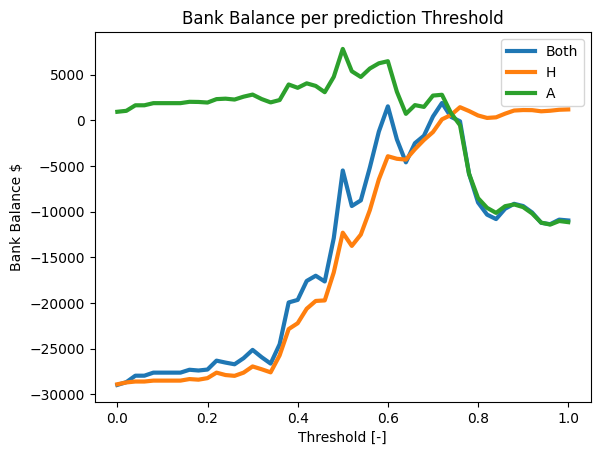

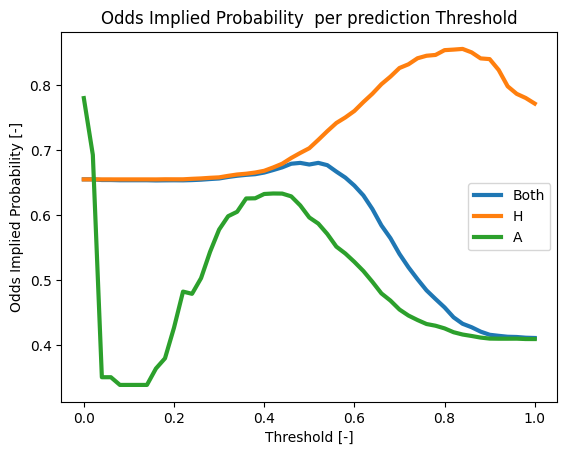

Max H: 1429.743
Max A: 7810.428


In [14]:
print("Ridge Regression - Train")
results_ridge_train = np.array(results_ridge_train)


plt.plot(thresholds, results_ridge_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_ridge_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_ridge_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_ridge_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_ridge_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_ridge_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_ridge_train[:, 1]):.3f}\nMax A: {max(results_ridge_train[:, 2]):.3f}")


Ridge Regression - Test


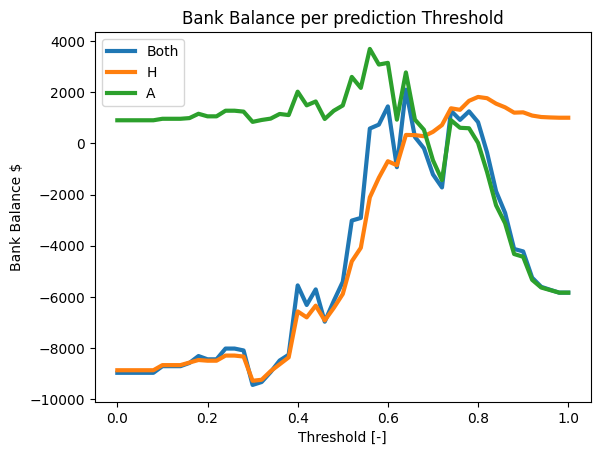

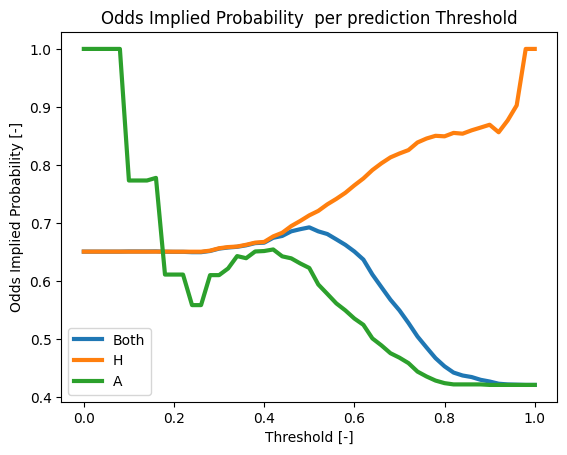

Max H: 1811.272
Max A: 3686.416


In [15]:
print("Ridge Regression - Test")
results_ridge_test = np.array(results_ridge_test)


plt.plot(thresholds, results_ridge_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_ridge_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_ridge_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_ridge_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_ridge_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_ridge_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_ridge_test[:, 1]):.3f}\nMax A: {max(results_ridge_test[:, 2]):.3f}")

Naive Bayes - Train


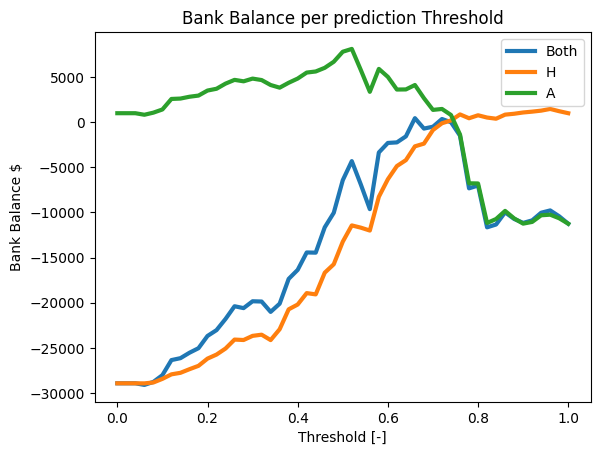

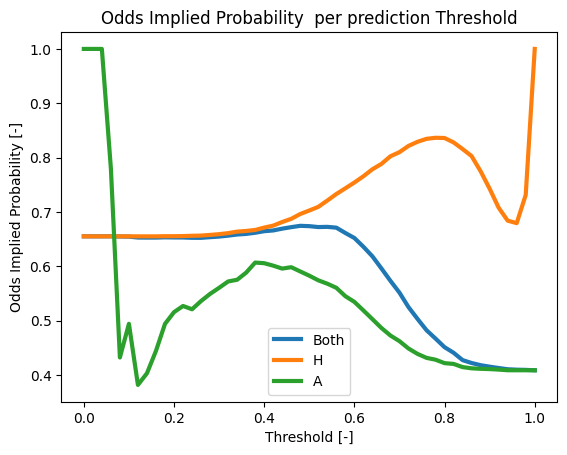

Max H: 1471.640
Max A: 8123.368


In [16]:
print("Naive Bayes - Train")
results_nb_train = np.array(results_nb_train)


plt.plot(thresholds, results_nb_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_nb_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_nb_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_nb_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_nb_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_nb_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_nb_train[:, 1]):.3f}\nMax A: {max(results_nb_train[:, 2]):.3f}")

Naive Bayes - Test


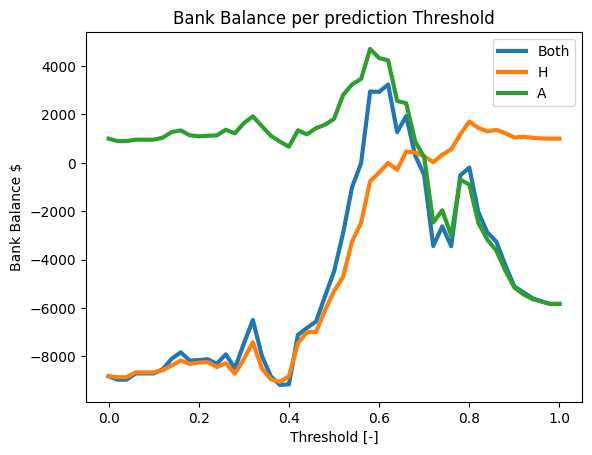

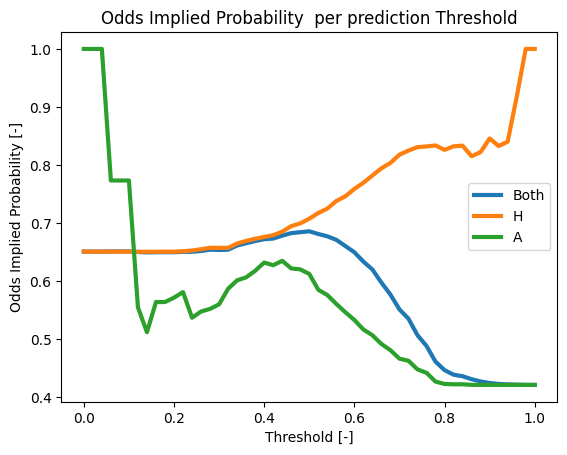

Max H: 1704.980
Max A: 4709.616


In [17]:
print("Naive Bayes - Test")
results_nb_test = np.array(results_nb_test)


plt.plot(thresholds, results_nb_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_nb_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_nb_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_nb_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_nb_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_nb_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_nb_test[:, 1]):.3f}\nMax A: {max(results_nb_test[:, 2]):.3f}")


Ridge Regression - Train - Kelly Strategy


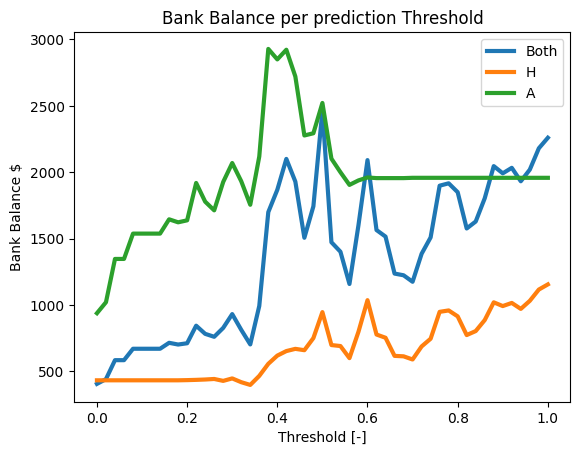

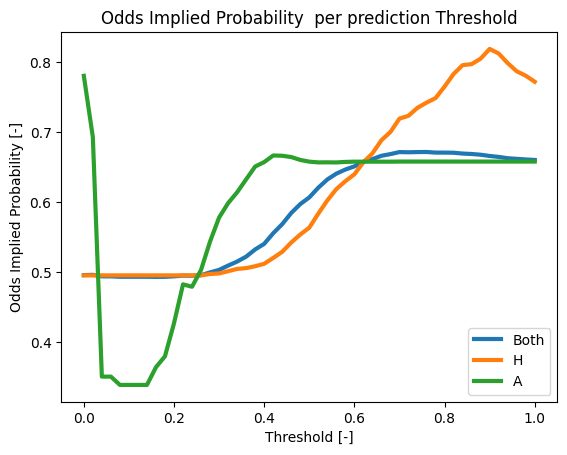

Max H: 1155.044
Max A: 2928.668


In [18]:
print("Ridge Regression - Train - Kelly Strategy")
results_kelly_ridge_train = np.array(results_kelly_ridge_train)


plt.plot(thresholds, results_kelly_ridge_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_ridge_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_ridge_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_ridge_train[:, 1]):.3f}\nMax A: {max(results_kelly_ridge_train[:, 2]):.3f}")

Ridge Regression - Test - Kelly Strategy


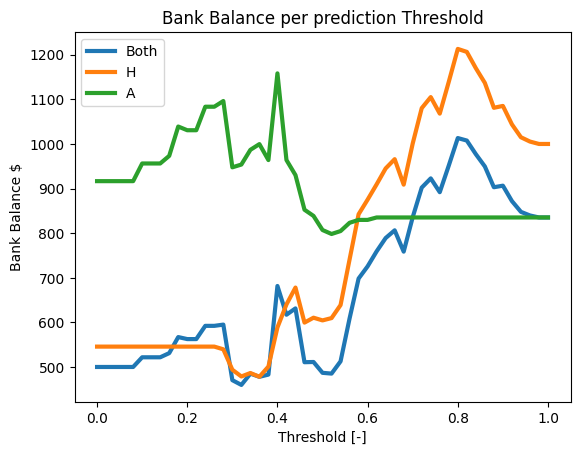

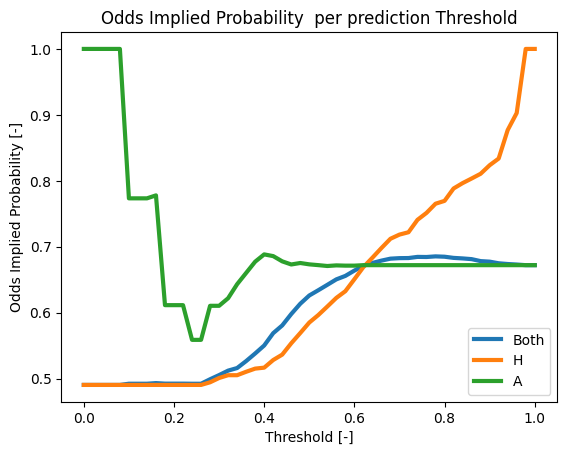

Max H: 1212.977
Max A: 1158.197


In [19]:
print("Ridge Regression - Test - Kelly Strategy")
results_kelly_ridge_test = np.array(results_kelly_ridge_test)


plt.plot(thresholds, results_kelly_ridge_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_ridge_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_ridge_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_ridge_test[:, 1]):.3f}\nMax A: {max(results_kelly_ridge_test[:, 2]):.3f}")

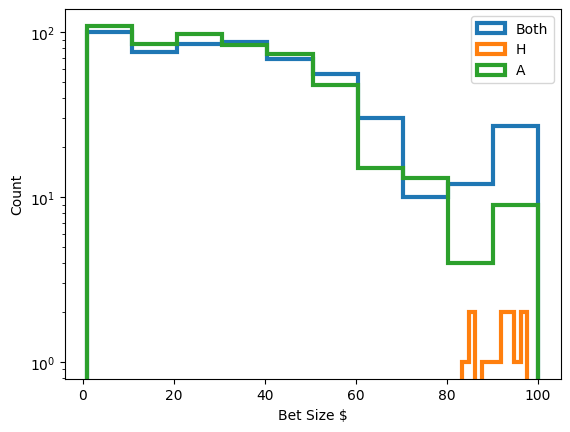

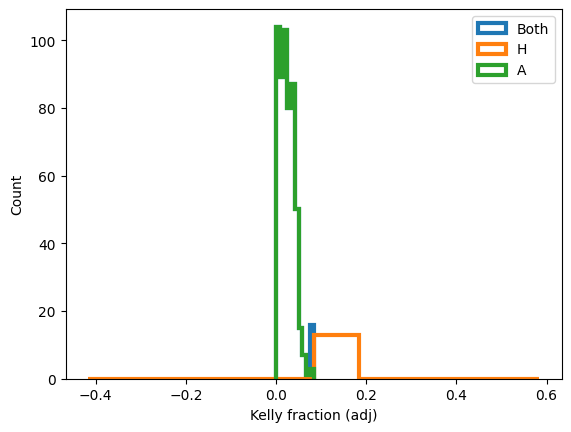

Min Kelly bet: 83.333
Max Kelly bet: 97.598
Min Kelly f: 0.000
Max Kelly f: 0.083


In [20]:
idx = np.argmax(results_kelly_ridge_train[:, 1])

plt.hist(bets_kelly_ridge_train[idx][0], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_ridge_train[idx][1], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_ridge_train[idx][2], histtype="step", lw=3, label="A")
plt.yscale("log")
plt.xlabel("Bet Size $")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.hist(bets_kelly_ridge_train[idx][3], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_ridge_train[idx][4], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_ridge_train[idx][5], histtype="step", lw=3, label="A")
plt.ylabel("Count")
plt.xlabel("Kelly fraction (adj)")
plt.legend()
plt.show()

print(f"Min Kelly bet: {min(bets_kelly_ridge_train[idx][1]):.3f}\nMax Kelly bet: {max(bets_kelly_ridge_train[idx][1]):.3f}")
print(f"Min Kelly f: {min(bets_kelly_ridge_train[idx][3]):.3f}\nMax Kelly f: {max(bets_kelly_ridge_train[idx][3]):.3f}")

Naive Bayes - Train - Kelly Strategy


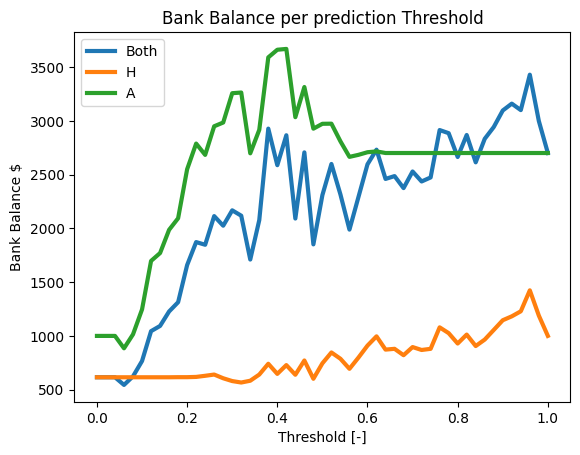

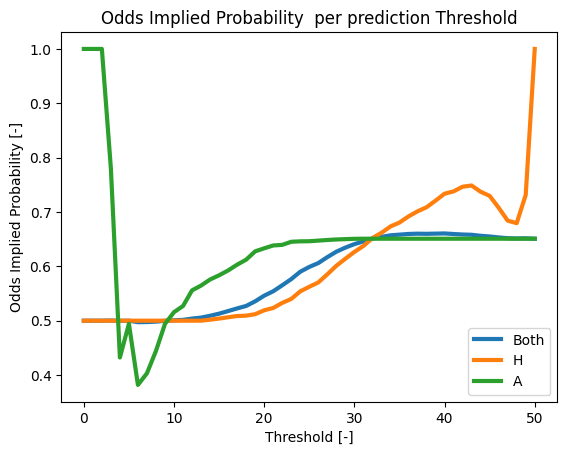

Max H: 1424.061
Max A: 3669.740


In [21]:
print("Naive Bayes - Train - Kelly Strategy")
results_kelly_nb_train = np.array(results_kelly_nb_train)


plt.plot(thresholds, results_kelly_nb_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_nb_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_nb_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(1 / results_kelly_nb_train[:, 3], lw=3, label="Both")
plt.plot(1 / results_kelly_nb_train[:, 4], lw=3, label="H")
plt.plot(1 / results_kelly_nb_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_nb_train[:, 1]):.3f}\nMax A: {max(results_kelly_nb_train[:, 2]):.3f}")

Naive Bayes - Test - Kelly Strategy


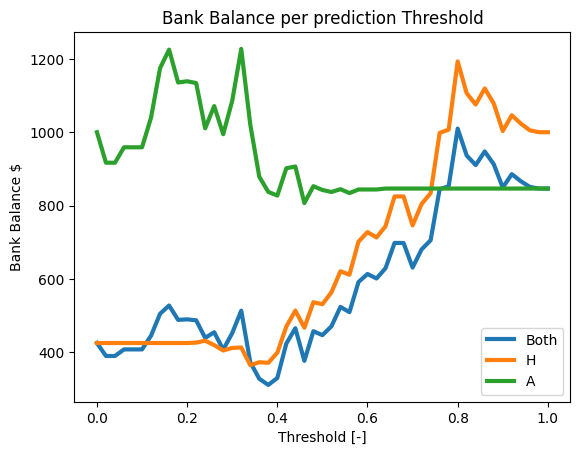

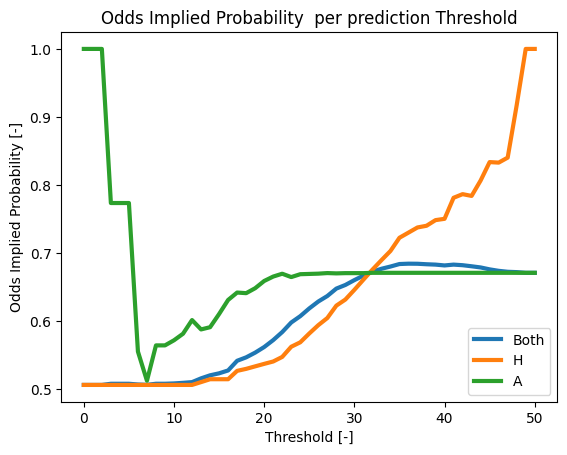

Max H: 1192.699
Max A: 1226.893


In [22]:
print("Naive Bayes - Test - Kelly Strategy")
results_kelly_nb_test = np.array(results_kelly_nb_test)


plt.plot(thresholds, results_kelly_nb_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_nb_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_nb_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(1 / results_kelly_nb_test[:, 3], lw=3, label="Both")
plt.plot(1 / results_kelly_nb_test[:, 4], lw=3, label="H")
plt.plot(1 / results_kelly_nb_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_nb_test[:, 1]):.3f}\nMax A: {max(results_kelly_nb_test[:, 2]):.3f}")




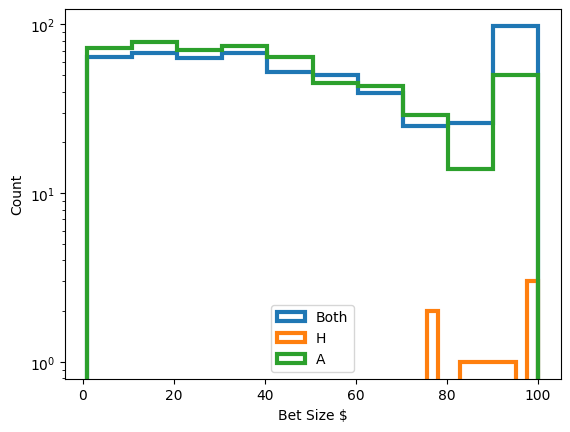

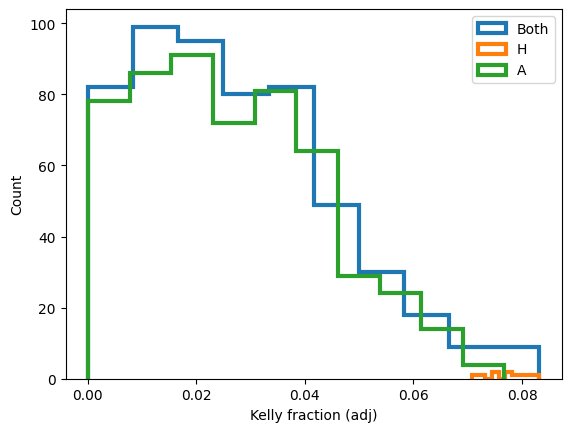

Min Kelly bet: 75.622
Max Kelly bet: 100.000
Min Kelly f: 0.000
Max Kelly f: 0.083


In [23]:
idx = np.argmax(results_kelly_nb_train[:, 1])

plt.hist(bets_kelly_nb_train[idx][0], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_nb_train[idx][1], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_nb_train[idx][2], histtype="step", lw=3, label="A")
plt.yscale("log")
plt.xlabel("Bet Size $")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.hist(bets_kelly_nb_train[idx][3], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_nb_train[idx][4], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_nb_train[idx][5], histtype="step", lw=3, label="A")
plt.ylabel("Count")
plt.xlabel("Kelly fraction (adj)")
plt.legend()
plt.show()

print(f"Min Kelly bet: {min(bets_kelly_nb_train[idx][1]):.3f}\nMax Kelly bet: {max(bets_kelly_nb_train[idx][1]):.3f}")
print(f"Min Kelly f: {min(bets_kelly_nb_train[idx][3]):.3f}\nMax Kelly f: {max(bets_kelly_nb_train[idx][3]):.3f}")